In [2]:
import pandas as pd
import gzip as gz
import re
import math
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity


In [3]:
#DECLARACION DE FUNCIONES

#Debido a que 2 de los 3 archivos json tienen un error (las claves de los diccionarios usan comilla simple,
#cuando la sintaxis de json requiere que sean comillas dobles) se crea la funcion crear_dataframe_jason_error la cual toma por argumento
#la ruta para acceder al archivo json comprimido, descomprime el mismo como texto, separa las lineas creando una lista de lineas,
#itera por cada una de ellas convirtiendolas en diccionarios mediante la funcion eval y guardando cada uno de ellos en una lista
#de diccionarios, luego se crea un dataframe con pandas a partir de dicha lista de diccionarios el cual retorna la funcion.
def crear_dataframe_json_error(path):
    with gz.open(path, 'rt', encoding='utf-8') as archivo:
        dataset = archivo.read()

    lineas = dataset.strip().split('\n')
    lista_de_diccionarios = []
    for linea in lineas:
        diccionario = eval(linea)
        lista_de_diccionarios.append(diccionario)
    
    df = pd.DataFrame(lista_de_diccionarios)

    return df

def CodificacionBinaria(df, columna):

    # Expandir las listas en nuevas columnas binarias
    datos_expandidos = pd.get_dummies(df[columna].apply(pd.Series).stack())
    datos_expandidos = datos_expandidos.groupby(level=0).sum()
    # Combinar el DataFrame original con las nuevas columnas binarias
    df = pd.concat([df, datos_expandidos], axis=1)
    # Eliminar la columna 'caracteristicas' original si es necesario
    df.drop(columna, axis=1, inplace=True)
    
    return df

#Funcion rellenar nulos del campo "id" con valores consecutivos
def rellenar_id(campo):
    id = campo.max() + 1
    lista = []
    for i, dato in enumerate(campo):
        if dato is None:
            lista.append(id)
            id += 1
        elif np.isnan(dato):
            lista.append(id)
            id += 1
        else:
            lista.append(dato)

    return pd.Series(lista)

#Funcion asignar valor a valores nulos y str de la variable precio
def asignar_precio(dato):
    global free
    if type(dato) == str:
        dato = dato.lower()

        if 'free' in dato:
            free.append(True)
            return float(0)#Si el dato contiene la palabra free se le asigna un precio $0
        
        elif 'starting' in dato:
            precio = '0'
            precio = re.findall(r'\$(\S+)', dato)
            precio = ''.join(precio)
            precio = float(precio)#Si el dato contiene la palabra starting y un valor numerico devuelve dicho valor, en el caso que no haya valor numerico devolvera 0
            free.append(False)
            return precio
        else:
            free.append(False)
            return float(0)
    else:
        free.append(False)        
        return dato

#Funcion extraer año de un string
def extraer_anio(dato):
    anio = '1900'
    if type(dato) == str:
        anio = re.findall(r'\d{4}', dato)
        anio= ''.join(anio)       
        return anio
    return dato

#Funcion quitar caracteres extraños
def limpiar(dato):
    if type(dato) == list:
        dato = '-'.join(dato)
        reemplazos = ["{", "}", "'", '[', ']', ':', ',', '"']
        for elemento in reemplazos:
            dato = dato.replace(elemento, "")
        dato = dato.strip()
        return dato
    elif type(dato) == str:
        dato = ''.join(dato)
        reemplazos = ["{", "}", "'", "", '[', ']', ':', ',', '"']
        for elemento in reemplazos:
            dato = dato.replace(elemento, "")
        dato = dato.strip()
        return dato
    else:
        return dato

#Funcion para imprimir un ejemplo no nulo de cada variable
def imprimir_ejemplos(df, variables = list):
    ejemplo = []
    titulo = []
    for elemento in variables:
        for valor in df[elemento]:
            flag = 0
            while valor != None and type(valor) != float:
                ejemplo.append(valor)
                titulo.append(elemento)
                flag = 1
                break
            while type(valor) == float and not math.isnan(valor):
                ejemplo.append(valor)
                titulo.append(elemento)
                flag = 1
                break
            if flag == 1:
                break
    for i in range(len(ejemplo)):
        print(titulo[i], ': ', ejemplo[i])

#Funcion analisis de sentimiento
def analisis_sentimiento(dato):
    analisis = TextBlob(dato)
    polaridad = analisis.sentiment.polarity
    if polaridad > 0:
        return 2
    elif polaridad < 0:
        return 0
    else:
        return 1
    
#Todos los datos str a minuscula
def str_minuscula(dato):
    if type(dato) == str:
        dato = dato.lower()
    return dato

In [4]:
#Se crea el dataframe df_steam_games con pandas accediendo directamente al archivo json ya que el mismo esta correcto
steam_games = pd.read_json("C:/Users/eduen/AppData/Local/Temp/steam_games.json.gz", lines=True, compression='gzip')

#Se crea el dataframe df_user_reviews a partir del archivo json utilizando la funcion crear_dataframe_json_error
user_reviews = crear_dataframe_json_error("C:/Users/eduen/AppData/Local/Temp/user_reviews.json.gz")

#Se crea el dataframe df_users_items a partir del archivo json utilizando la funcion crear_dataframe_json_error
users_items = crear_dataframe_json_error("C:/Users/eduen/AppData/Local/Temp/users_items.json.gz")


In [13]:
#DECLARACION DE FUNCIONES

#Debido a que 2 de los 3 archivos json tienen un error (las claves de los diccionarios usan comilla simple,
#cuando la sintaxis de json requiere que sean comillas dobles) se crea la funcion crear_dataframe_jason_error la cual toma por argumento
#la ruta para acceder al archivo json comprimido, descomprime el mismo como texto, separa las lineas creando una lista de lineas,
#itera por cada una de ellas convirtiendolas en diccionarios mediante la funcion eval y guardando cada uno de ellos en una lista
#de diccionarios, luego se crea un dataframe con pandas a partir de dicha lista de diccionarios el cual retorna la funcion.
def crear_dataframe_json_error(path):
    with gz.open(path, 'rt', encoding='utf-8') as archivo:
        dataset = archivo.read()

    lineas = dataset.strip().split('\n')
    lista_de_diccionarios = []
    for linea in lineas:
        diccionario = eval(linea)
        lista_de_diccionarios.append(diccionario)
    
    df = pd.DataFrame(lista_de_diccionarios)

    return df

#Funcion codificacion binaria
def codificacion_binaria_genero(df, columna):

    # Expandir las listas en nuevas columnas binarias
    datos_expandidos = pd.get_dummies(df[columna].apply(pd.Series).stack())
    datos_expandidos = datos_expandidos.groupby(level=0).sum()
    # Combinar el DataFrame original con las nuevas columnas binarias
    df = pd.concat([df, datos_expandidos], axis=1)
    # Eliminar la columna 'caracteristicas' original si es necesario
    df.drop(columna, axis=1, inplace=True)
    
    return df

#Funcion codificacion binaria
def codificacion_binaria_universal(df, columna):

    # Expandir las listas en nuevas columnas binarias
    stack = df[columna].apply(pd.Series).stack().head(100)
    datos_expandidos = pd.get_dummies(stack)
    datos_expandidos = datos_expandidos.groupby(level=0).sum()
    # Combinar el DataFrame original con las nuevas columnas binarias
    df = pd.concat([df, datos_expandidos], axis=1)
    # Eliminar la columna 'caracteristicas' original si es necesario
    df.drop(columna, axis=1, inplace=True)
    
    return df

#Funcion asignar valor a valores nulos y str de la variable precio
def asignar_precio(dato):
    global free
    if type(dato) == str:
        dato = dato.lower()

        if 'free' in dato:
            free.append(True)
            return float(0)#Si el dato contiene la palabra free se le asigna un precio $0
        
        elif 'starting' in dato:
            precio = '0'
            precio = re.findall(r'\$(\S+)', dato)
            precio = ''.join(precio)
            precio = float(precio)#Si el dato contiene la palabra starting y un valor numerico devuelve dicho valor, en el caso que no haya valor numerico devolvera 0
            free.append(False)
            return precio
        else:
            free.append(False)
            return float(0)
    else:
        free.append(False)        
        return dato

#Funcion extraer año de un string
def extraer_anio(dato):
    anio = '1900'
    if type(dato) == str:
        anio = re.findall(r'\d{4}', dato)
        anio= ''.join(anio)       
        return anio
    return dato

#Funcion quitar caracteres extraños
def limpiar(dato):
    if type(dato) == list:
        dato = '-'.join(dato)
        reemplazos = ["{", "}", "'", '[', ']', ':', ',', '"', ';', '/']
        for elemento in reemplazos:
            dato = dato.replace(elemento, "")
        dato = dato.strip()
        return dato
    elif type(dato) == str:
        dato = ''.join(dato)
        reemplazos = ["{", "}", "'", "", '[', ']', ':', ',', '"', ';', '/']
        for elemento in reemplazos:
            dato = dato.replace(elemento, "")
        dato = dato.strip()
        return dato
    else:
        return dato

#Funcion analisis de sentimiento
def analisis_sentimiento(dato):
    analisis = TextBlob(dato)
    polaridad = analisis.sentiment.polarity
    if polaridad > 0:
        return 2
    elif polaridad < 0:
        return 0
    else:
        return 1
    
#Funcion para transformar todos los datos str a minuscula (facilita lectura endpoints)
def str_minuscula(dato):
    if type(dato) == str:
        dato = dato.lower()
    return dato




df_steam_games = steam_games.copy()
#Eliminar filas repetidas en funcion del campo 'id'
df_steam_games = df_steam_games.dropna(subset=['id'])
df_steam_games = df_steam_games.drop_duplicates(subset=['id'])
df_steam_games.loc[:, 'item_id'] = df_steam_games['id']
#Desanidar genres realizando codificacion binaria
df_genres = codificacion_binaria_genero(df_steam_games[['item_id','genres']], 'genres')
df_steam_games = pd.merge(df_steam_games, df_genres, on='item_id', how='outer')
#Desanidar tags, specs y developer realizando codificacion binaria limitada hasta 100 elementos por fila
df_tags = codificacion_binaria_universal(df_steam_games[['item_id','tags']], 'tags')
df_specs = codificacion_binaria_universal(df_steam_games[['item_id','specs']], 'specs')
df_developer = codificacion_binaria_universal(df_steam_games[['item_id','developer']], 'developer')
df_steam_games = df_steam_games.drop(columns= ['genres', 'id'])
df_steam_games = df_steam_games.drop_duplicates(subset='item_id')
#Convertir 'item_id' de genres a entero
df_genres['item_id'] = df_genres['item_id'].astype(int)
#Eliminar filas que no contengan valor en 'title'
df_steam_games = df_steam_games.dropna(subset=['title'])
#Reemplazar los valores tipo str por numericos en el campo 'price'
free = []
df_steam_games['price'] = df_steam_games['price'].apply(asignar_precio)
#Reemplazar valores nulos por la media en 'price'
df_steam_games['price'] = df_steam_games['price'].fillna(df_steam_games['price'].mean())
#Extraer año de fechas
df_steam_games['release_date'] = df_steam_games['release_date'].apply(extraer_anio)
#Campo 'release_date' a formato fecha
df_steam_games['release_date'] = pd.to_datetime(df_steam_games['release_date'], format= '%Y', errors= 'coerce').dt.year
df_steam_games['release_date'] = df_steam_games['release_date'].astype(str)
df_steam_games['release_date'] = df_steam_games['release_date'].apply(lambda x: x[:4])
df_steam_games['release_date'] = pd.to_numeric(df_steam_games['release_date'], errors='coerce')
df_steam_games = df_steam_games.dropna(subset='release_date')
df_steam_games['release_date'] = df_steam_games['release_date'].astype(int)
#Reemplazar datos nulos de variables categoricas por la leyenda 'Dato Desconocido'
lista_columnas = ['publisher', 'title', 'url', 'tags', 'specs', 'developer']
for elemento in lista_columnas:
    df_steam_games[elemento].fillna('Dato Desconocido', inplace= True)
    df_steam_games[elemento] = df_steam_games[elemento].astype(str)
#Convertir 'item_id' a entero
df_steam_games['item_id'] = df_steam_games['item_id'].astype(int)
df_steam_games = df_steam_games.drop_duplicates()
df_steam_games = df_steam_games.map(str_minuscula)
df_steam_games = df_steam_games.map(limpiar)

df_steam_games.to_parquet('steam_games', index= False)

#Dataset user_reviews
df_user_reviews = user_reviews.copy()
df_lista = []
for indice, linea in df_user_reviews.iterrows():
    df = pd.DataFrame(linea['reviews'])
    df['user_id'] = linea['user_id']
    df_lista.append(df)

df_user_reviews = pd.concat(df_lista, ignore_index=True)
#Feature engineering
df_user_reviews['sentiment_analysis'] = df_user_reviews['review'].apply(analisis_sentimiento)
#Eliminar la columna last_edited por poseer faltantes
df_user_reviews = df_user_reviews.drop(columns=['last_edited', 'helpful', 'funny'])
df_user_reviews = df_user_reviews.drop_duplicates()
df_user_reviews['posted'] = df_user_reviews['posted'].apply(extraer_anio)
df_user_reviews['posted'] = df_user_reviews['posted'].astype(str)
df_user_reviews['posted'] = df_user_reviews['posted'].apply(lambda x: x[:4])
df_user_reviews['posted'] = pd.to_numeric(df_user_reviews['posted'], errors='coerce')
df_user_reviews = df_user_reviews.dropna(subset='posted')
df_user_reviews['posted'] = df_user_reviews['posted'].astype(int)
df_user_reviews = df_user_reviews.map(limpiar)
df_user_reviews = df_user_reviews.map(str_minuscula)
df_user_reviews['item_id'] = df_user_reviews['item_id'].astype(int)

df_user_reviews.to_parquet('user_reviews', index= False)

df_users_items = users_items.copy()
df_lista = []
for indice, linea in df_users_items.iterrows():
    df = pd.DataFrame(linea['items'])
    df['user_id'] = linea['user_id']
    df['items_count'] = linea['items_count']
    df['steam_id'] = linea['steam_id']
    df['user_url'] = linea['user_url']
    df_lista.append(df)

df_users_items = pd.concat(df_lista, ignore_index=True)
df_users_items = df_users_items.drop(columns= ['item_name', 'steam_id']) #User id y Steam id poseen datos identicos.
df_users_items = df_users_items.drop_duplicates()
df_users_items = df_users_items.dropna()
df_users_items = df_users_items.map(limpiar)
df_users_items = df_users_items.map(str_minuscula)
df_users_items['user_id'] = df_users_items['user_id'].astype(str)
df_users_items['item_id'] = df_users_items['item_id'].astype(int)
df_users_items['playtime_forever'] = df_users_items['playtime_forever'].astype(int)

df_users_items.to_parquet('users_items', index= False)
#Crear dataframe genero relacionado con items, fecha de lanzamiento y usuarios.
genero = pd.merge(df_steam_games[['item_id', 'release_date']], df_genres, on='item_id', how='outer')
genero = pd.merge(genero, df_users_items[['item_id', 'playtime_forever', 'user_id']], on='item_id', how='outer')
genero = genero.drop_duplicates(subset='item_id')
genero['playtime_forever'] = genero['playtime_forever'].fillna(0)
genero['playtime_forever'] = genero['playtime_forever'].astype(int)
genero['release_date'] = genero['release_date'].fillna(0)
genero['release_date'] = genero['release_date'].astype(int)
genero['item_id'] = genero['item_id'].astype(int)

#DF para endpoint 1
timeforgenre = genero.copy()
lista_df = []
for x in timeforgenre.columns:
    if x != 'item_id' and x != 'release_date' and x != 'playtime_forever' and x != 'user_id':
        df = timeforgenre[timeforgenre[x] == 1]
        df = df.groupby('release_date')['playtime_forever'].sum().reset_index()
        df['genero'] = x
        lista_df.append(df)
    else:
        continue
timeforgenre = pd.concat(lista_df, ignore_index=True)
timeforgenre = timeforgenre.drop_duplicates()

timeforgenre.to_parquet('timeforgenre', index= False)

#DF para endpoint 2
userforgenre = genero.copy()
lista_df = []
for x in userforgenre.columns:
    if x != 'item_id' and x != 'release_date' and x != 'playtime_forever' and x != 'user_id':
        df = userforgenre[userforgenre[x] == 1]
        df = df.groupby(['user_id', 'release_date'])['playtime_forever'].sum().reset_index()
        df['genero'] = x
        lista_df.append(df)
    else:
        continue
userforgenre = pd.concat(lista_df, ignore_index=True)
userforgenre = userforgenre.drop_duplicates()

userforgenre.to_parquet('userforgenre', index= False)

#DF para endpoint 3 y 4
recommend = pd.merge(df_steam_games[['item_id', 'title']], df_user_reviews[['item_id', 'posted', 'recommend', 'sentiment_analysis']], on='item_id', how='outer')
recommend = recommend.groupby(['item_id', 'title', 'posted'])[['recommend', 'sentiment_analysis']].mean().reset_index()
recommend['puntaje_recomendacion'] = recommend['recommend'] + recommend['sentiment_analysis']
recommend = recommend.drop(columns= ['recommend', 'sentiment_analysis'])
recommend = recommend.drop_duplicates()
recommend['item_id'] = recommend['item_id'].astype(int)

recommend.to_parquet('recommend', index= False)

sentiment_analysis = pd.merge(df_steam_games[['item_id', 'release_date']], df_user_reviews[['item_id', 'sentiment_analysis']], on='item_id', how='outer')
sentiment_analysis = sentiment_analysis.dropna(subset='release_date')
sentiment_analysis['positivo'] = sentiment_analysis['sentiment_analysis'].apply(lambda x: True if x == 2 else False)
sentiment_analysis['neutral'] = sentiment_analysis['sentiment_analysis'].apply(lambda x: True if x == 1 else False)
sentiment_analysis['negativo'] = sentiment_analysis['sentiment_analysis'].apply(lambda x: True if x == 0 else False)
sentiment_analysis = sentiment_analysis.groupby('release_date')[['positivo', 'neutral', 'negativo']].sum().reset_index()

sentiment_analysis.to_parquet('sentiment_analysis', index= False)

#Sistema de recomendacion
puntaje_recomendacion = recommend.copy()
puntaje_recomendacion = puntaje_recomendacion.groupby('item_id')['puntaje_recomendacion'].mean().reset_index()

items_recomendacion = pd.merge(df_steam_games, puntaje_recomendacion, on='item_id', how='outer' )
items_recomendacion = pd.merge(items_recomendacion, df_tags, on='item_id', how='outer' )
items_recomendacion = pd.merge(items_recomendacion, df_specs, on='item_id', how='outer' )
items_recomendacion = pd.merge(items_recomendacion, df_developer, on='item_id', how='outer' )
items_recomendacion = items_recomendacion.drop_duplicates(subset='item_id')
items_recomendacion = items_recomendacion.dropna(subset='title')
items_recomendacion['item_id'] = items_recomendacion['item_id'].astype(int)
label_encoder = LabelEncoder()
for col in items_recomendacion.columns:
    if col != 'item_id' and col != 'title' and col != 'puntaje_recomendacion':
        items_recomendacion[col] = label_encoder.fit_transform(items_recomendacion[col])
items_recomendacion = items_recomendacion.fillna(0)

items_recomendacion.to_parquet('items_recomendacion', index= False)

#User id



In [12]:
df_users_items


,item_id,playtime_forever,playtime_2weeks,user_id,items_count,user_url
0,10,6,0.0,76561197970982479,277,httpsteamcommunity.comprofiles76561197970982479
1,20,0,0.0,76561197970982479,277,httpsteamcommunity.comprofiles76561197970982479
2,30,7,0.0,76561197970982479,277,httpsteamcommunity.comprofiles76561197970982479
3,40,0,0.0,76561197970982479,277,httpsteamcommunity.comprofiles76561197970982479
4,50,0,0.0,76561197970982479,277,httpsteamcommunity.comprofiles76561197970982479
...,...,...,...,...,...,...
5153204,346330,0,0.0,76561198329548331,7,httpsteamcommunity.comprofiles76561198329548331
5153205,373330,0,0.0,76561198329548331,7,httpsteamcommunity.comprofiles76561198329548331
5153206,388490,3,3.0,76561198329548331,7,httpsteamcommunity.comprofiles76561198329548331
5153207,521570,4,4.0,76561198329548331,7,httpsteamcommunity.comprofiles76561198329548331


DATASET STEAM_GAMES

In [23]:
primer_iteracion = 0
for col in playtimegenre.columns:
    if primer_iteracion == 0:
        primer_iteracion = 1
        continue

    if playtimegenre[col].dtype == 'float64':  # Verifica si la columna es de tipo entero (puedes ajustar el tipo según tu caso)
        playtimegenre[col] = playtimegenre[col].apply(lambda x: col if x == 1 else None)
playtimegenre

,item_id,release_date,Accounting,Action,Adventure,Animation &amp; Modeling,Audio Production,Casual,Design &amp; Illustration,Early Access,...,RPG,Racing,Simulation,Software Training,Sports,Strategy,Utilities,Video Production,Web Publishing,playtime_forever
0,282010.0,1997,None,Action,None,None,None,None,None,None,...,None,Racing,None,None,None,None,None,None,None,None
1,282010.0,1997,None,Action,None,None,None,None,None,None,...,None,Racing,None,None,None,None,None,None,None,None
2,282010.0,1997,None,Action,None,None,None,None,None,None,...,None,Racing,None,None,None,None,None,None,None,None
3,282010.0,1997,None,Action,None,None,None,None,None,None,...,None,Racing,None,None,None,None,None,None,None,None
4,282010.0,1997,None,Action,None,None,None,None,None,None,...,None,Racing,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4173910,80.0,2004,None,Action,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4173911,80.0,2004,None,Action,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4173912,80.0,2004,None,Action,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4173913,80.0,2004,None,Action,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [65]:
#Obtener informacion del dataset
steam_games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30084 entries, 88310 to 120443
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   publisher     30084 non-null  object 
 1   genres        30084 non-null  object 
 2   app_name      30084 non-null  object 
 3   title         30084 non-null  object 
 4   url           30084 non-null  object 
 5   release_date  29963 non-null  float64
 6   tags          30084 non-null  object 
 7   reviews_url   30084 non-null  object 
 8   specs         30084 non-null  object 
 9   price         30084 non-null  float64
 10  early_access  30084 non-null  float64
 11  id            30084 non-null  float64
 12  developer     30084 non-null  object 
 13  item_id       30084 non-null  int64  
dtypes: float64(4), int64(1), object(9)
memory usage: 3.4+ MB


In [59]:
#Clasificar en variables categoricas o numericas, luego almacenar en dos listas diferentes.
variables_categoricas = ['publisher', 'genres', 'app_name', 'title', 'url', 'release_date', 'tags', 'reviews_url', 'specs', 'early_access', 'id', 'developer']

variables_numericas = ['price']

EJEMPLO NO NULO DE VARIABLES NUMERICAS

In [60]:
imprimir_ejemplos(steam_games, variables_numericas)


price :  4.99


EJEMPLO NO NULO DE VARIABLES CATEGORICAS

In [61]:
imprimir_ejemplos(steam_games, variables_categoricas)

publisher :  Kotoshiro
genres :  ['Action', 'Casual', 'Indie', 'Simulation', 'Strategy']
app_name :  Lost Summoner Kitty
title :  Lost Summoner Kitty
url :  http://store.steampowered.com/app/761140/Lost_Summoner_Kitty/
release_date :  2018-01-04
tags :  ['Strategy', 'Action', 'Indie', 'Casual', 'Simulation']
reviews_url :  http://steamcommunity.com/app/761140/reviews/?browsefilter=mostrecent&p=1
specs :  ['Single-player']
early_access :  0.0
id :  761140.0
developer :  Kotoshiro


In [62]:
steam_games['release_date'].unique()

array([None, '2018-01-04', '2017-07-24', ..., '2016-11-19',
       'January 2018', '2018-10-01'], dtype=object)

TRANSFORMACIONES DATASET STEAM_GAMES

- Se eliminaran las columnas 'user_id', 'steam_id', 'items' e 'items_count' por tratarse de datos de usuarios, los mismos seran
tratados en el dataset users_items con el objetivo de no contaminar ni sesgar los datos de videojuegos.
- Se eliminaran todas las filas en la que la variable 'id' posea valores nulos y se eliminaran los duplicados en funcion de 'id' debido a que el mismo es campo clave.
- Eliminar filas que no contengan valor en 'title' ya que si bien no es el campo clave, es una variable relevante para cualquier futuro analisis.
- La variable 'price' arroja el precio de venta de cada juego, la misma se debe procesar como una variable numerica,
los valores categoricos dentro de la misma se analizaran individualmente y se reemplazaran por el valor que corresponda
en caso de ser gratuito se reemplazara por cero y en caso de tener un valor minimo se reemplazara por el mismo.
- La variable 'metascore' arroja la puntuacion del juego obtenida por el sitio Metascore, dicha variable al
poseer mas del 90% de datos faltantes respecto a la variable 'title' se considerara irrelevante y se eliminara.
- La variable 'release_date' contiene la fecha de lanzamiento de cada item. Los valores nulos seran reemplazados por 
el valor '1900-01-01', analizando valores unicos hallamos 'January 2018' el cual sera reemplazado por '2018-01-01'
Modificar tipos de dato incorrectos, variables categoricas: str, variables numericas: float, fechas:date
Manejo de valores nulos en variables numericas:
- Con el objetivo de no dificultar calculos matematicos todos los valores nulos de las variables numericas
se reemplazaran por valores numericos.
- La variable discount_price arroja el precio de descuento correspondiente, si bien posee un alto
porcentaje de valores nulos la misma sigue siendo relevante para el calculo de gasto monetario
por usuario. al ser una variable independiente y especifica se reemplazaran los valores nulos por cero
asumiendo que dichos items no poseen descuento
- La variable price arroja el precio de venta de cada juego, se reemplazaran los nulos por el valor
medio asumiendo un error o perdida del dato, ya que se considera quesi el precio fuera cero deberia encontrarse
almacenado como tal.
- Los valores nulos de las variables categoricas se reemplazaran por la leyenda 'Dato Desconocido'


ETL DF STEAM GAMES

In [17]:
df_steam_games = steam_games.copy()
#Rellenar todas las filas en la que el campo 'id' posea valores nulos con valores contiguos
df_steam_games['id'] = rellenar_id(df_steam_games['id'])
#Eliminar filas repetidas en funcion del campo 'id'
df_steam_games = df_steam_games.drop_duplicates(subset=['id'])
df_steam_games.loc[:, 'item_id'] = df_steam_games['id']
#Desanidar genres, tags, specs realizando codificacion binaria
df_genres = CodificacionBinaria(df_steam_games[['item_id','genres']], 'genres')
df_steam_games = df_steam_games.drop(columns= 'genres')
df_steam_games = pd.merge(df_steam_games, df_genres, on='item_id', how='inner')
#Eliminar filas que no contengan valor en 'title'
df_steam_games = df_steam_games.dropna(subset=['title'])
#Reemplazar los valores tipo str por numericos en el campo 'price'
free = []
df_steam_games['price'] = df_steam_games['price'].apply(asignar_precio)
#Reemplazar valores nulos por la media en 'price'
df_steam_games['price'] = df_steam_games['price'].fillna(df_steam_games['price'].mean())
#Extraer año de fechas
df_steam_games['release_date'] = df_steam_games['release_date'].apply(extraer_anio)
#Campo 'release_date' a formato fecha
df_steam_games['release_date'] = pd.to_datetime(df_steam_games['release_date'], format= '%Y', errors= 'coerce').dt.year
df_steam_games['release_date'] = df_steam_games['release_date'].astype(str)
#Reemplazar datos nulos de variables categoricas por la leyenda 'Dato Desconocido'
lista_columnas = ['publisher', 'title', 'url', 'release_date','tags', 'specs', 'developer']
for elemento in lista_columnas:
    df_steam_games[elemento].fillna('Dato Desconocido', inplace= True)
    df_steam_games[elemento] = df_steam_games[elemento].astype(str)
#Convertir 'item_id' a entero
df_steam_games['item_id'] = df_steam_games['item_id'].astype(int)
df_steam_games = df_steam_games.drop_duplicates()
df_steam_games = df_steam_games.map(str_minuscula)
df_steam_games = df_steam_games.map(limpiar)

df_steam_games.to_parquet('steam_games', index= False)

#Dataset user_reviews
df_user_reviews = user_reviews.copy()
df_lista = []
for indice, linea in df_user_reviews.iterrows():
    df = pd.DataFrame(linea['reviews'])
    df['user_id'] = linea['user_id']
    df_lista.append(df)

df_user_reviews = pd.concat(df_lista, ignore_index=True)
#Feature engineering
df_user_reviews['sentiment_analysis'] = df_user_reviews['review'].apply(analisis_sentimiento)
#Eliminar la columna last_edited por poseer faltantes
df_user_reviews = df_user_reviews.drop(columns=['last_edited', 'helpful', 'funny'])
df_user_reviews = df_user_reviews.drop_duplicates()
df_user_reviews['posted'] = df_user_reviews['posted'].apply(extraer_anio)
df_user_reviews = df_user_reviews.map(limpiar)
df_user_reviews = df_user_reviews.map(str_minuscula)

df_user_reviews.to_parquet('user_reviews', index= False)

df_users_items = users_items.copy()
df_lista = []
for indice, linea in df_users_items.iterrows():
    df = pd.DataFrame(linea['items'])
    df['user_id'] = linea['user_id']
    df['items_count'] = linea['items_count']
    df['steam_id'] = linea['steam_id']
    df['user_url'] = linea['user_url']
    df_lista.append(df)

df_users_items = pd.concat(df_lista, ignore_index=True)
df_users_items = df_users_items.drop(columns= 'item_name')
df_users_items = df_users_items.drop_duplicates()
df_users_items = df_users_items.dropna()
df_users_items = df_users_items.map(limpiar)
df_users_items = df_users_items.map(str_minuscula)

df_users_items.to_parquet('users_items', index= False)

In [3]:
df_users_items = users_items
df_lista = []
for indice, linea in df_users_items.iterrows():
    df = pd.DataFrame(linea['items'])
    df['user_id'] = linea['user_id']
    df['items_count'] = linea['items_count']
    df['steam_id'] = linea['steam_id']
    df['user_url'] = linea['user_url']
    df_lista.append(df)

df_users_items = pd.concat(df_lista, ignore_index=True)
df_users_items = df_users_items.drop(columns= 'item_name')
df_users_items = df_users_items.drop_duplicates()
df_users_items = df_users_items.dropna()

df_users_items


NameError: name 'users_items' is not defined


A continuacion se lee el data frame con las primeras modificaciones realizadas en el ETL

In [21]:
df_user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58431 entries, 0 to 59304
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   posted              58431 non-null  object
 1   item_id             58431 non-null  object
 2   recommend           58431 non-null  bool  
 3   review              58431 non-null  object
 4   user_id             58431 non-null  object
 5   sentiment_analysis  58431 non-null  int64 
dtypes: bool(1), int64(1), object(4)
memory usage: 2.7+ MB


In [38]:
df_steam_games

,publisher,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,item_id,free
0,kotoshiro,lost summoner kitty,lost summoner kitty,http//store.steampowered.com/app/761140/lost_s...,2018,strategy-action-indie-casual-simulation,http//steamcommunity.com/app/761140/reviews/?b...,single-player,4.99,False,761140,False
1,making fun inc.,ironbound,ironbound,http//store.steampowered.com/app/643980/ironbo...,2018,free to play-strategy-indie-rpg-card game-trad...,http//steamcommunity.com/app/643980/reviews/?b...,single-player-multi-player-online multi-player...,0.00,False,643980,True
2,poolians.com,real pool 3d - poolians,real pool 3d - poolians,http//store.steampowered.com/app/670290/real_p...,2017,free to play-simulation-sports-casual-indie-mu...,http//steamcommunity.com/app/670290/reviews/?b...,single-player-multi-player-online multi-player...,0.00,False,670290,True
3,彼岸领域,弹炸人2222,弹炸人2222,http//store.steampowered.com/app/767400/2222/,2017,action-adventure-casual,http//steamcommunity.com/app/767400/reviews/?b...,single-player,0.99,False,767400,False
4,trickjump games ltd,battle royale trainer,battle royale trainer,http//store.steampowered.com/app/772540/battle...,2018,action-adventure-simulation-fps-shooter-third-...,http//steamcommunity.com/app/772540/reviews/?b...,single-player-steam achievements,3.99,False,772540,False
...,...,...,...,...,...,...,...,...,...,...,...,...
30079,bidoniera games,kebab it up!,kebab it up!,http//store.steampowered.com/app/745400/kebab_...,2018,action-indie-casual-violent-adventure,http//steamcommunity.com/app/745400/reviews/?b...,single-player-steam achievements-steam cloud,1.99,False,745400,False
30080,ghost_rus games,colony on mars,colony on mars,http//store.steampowered.com/app/773640/colony...,2018,strategy-indie-casual-simulation,http//steamcommunity.com/app/773640/reviews/?b...,single-player-steam achievements,1.99,False,773640,False
30081,sacada,logistical south africa,logistical south africa,http//store.steampowered.com/app/733530/logist...,2018,strategy-indie-casual,http//steamcommunity.com/app/733530/reviews/?b...,single-player-steam achievements-steam cloud-s...,4.99,False,733530,False
30082,laush studio,russian roads,russian roads,http//store.steampowered.com/app/610660/russia...,2018,indie-simulation-racing,http//steamcommunity.com/app/610660/reviews/?b...,single-player-steam achievements-steam trading...,1.99,False,610660,False


In [35]:
df_steam_games.describe()

,release_date,price,item_id
count,30084.000000,30084.000000,3.008400e+04
mean,2014.308337,8.888783,4.440590e+05
std,8.062132,16.255203,1.844744e+05
min,1900.000000,0.000000,1.000000e+01
25%,2014.000000,2.990000,3.218375e+05
50%,2016.000000,4.990000,4.383050e+05
75%,2017.000000,9.990000,5.889800e+05
max,2021.000000,995.000000,2.117162e+06


ANALISIS UNIVARIABLE

Variables Categoricas:

Representacion visual utilizando nubes de palabras y porcentajes de las 10 palabras mas frecuentes en variables categoricas

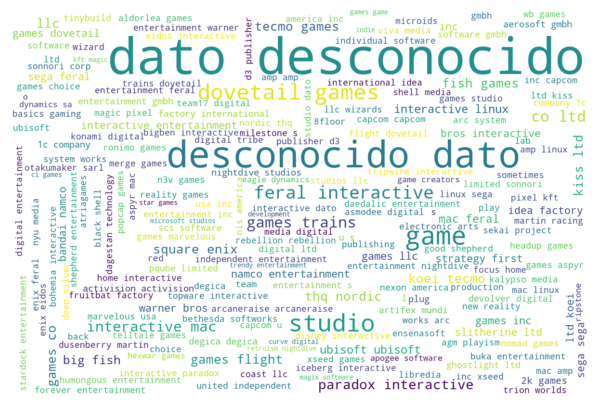

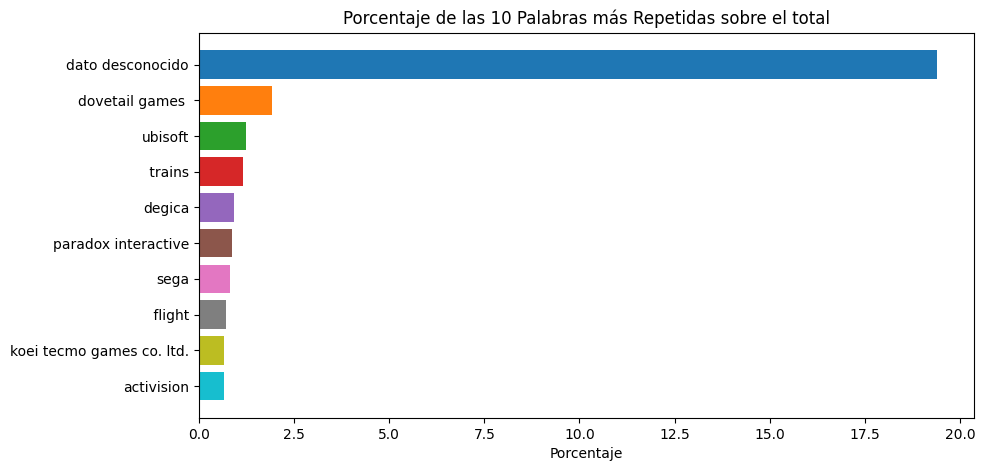

In [149]:
repres_categoricas(df_steam_games, 'publisher')

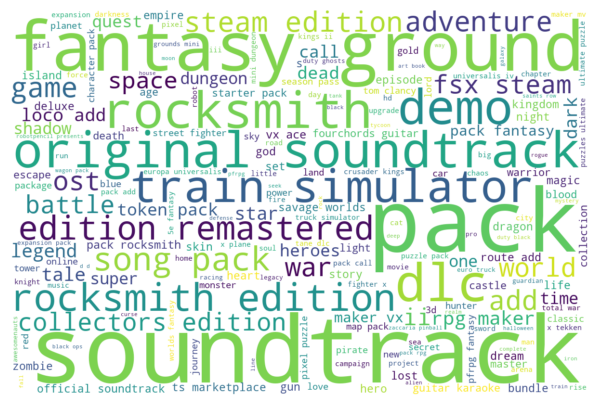

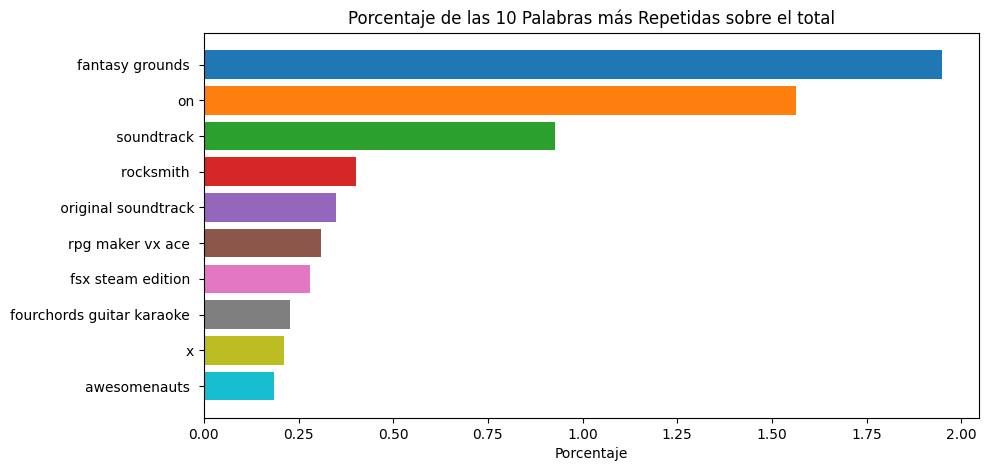

In [150]:
repres_categoricas(df_steam_games, 'app_name')

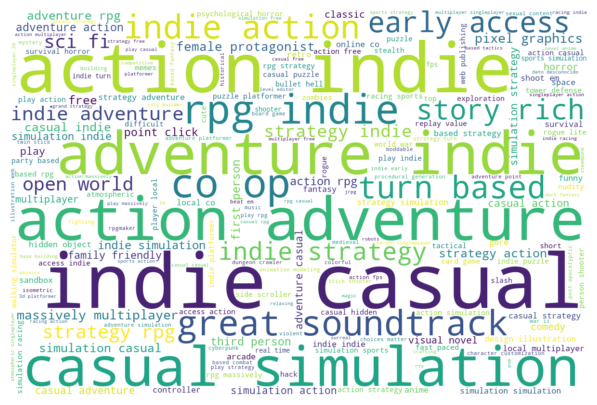

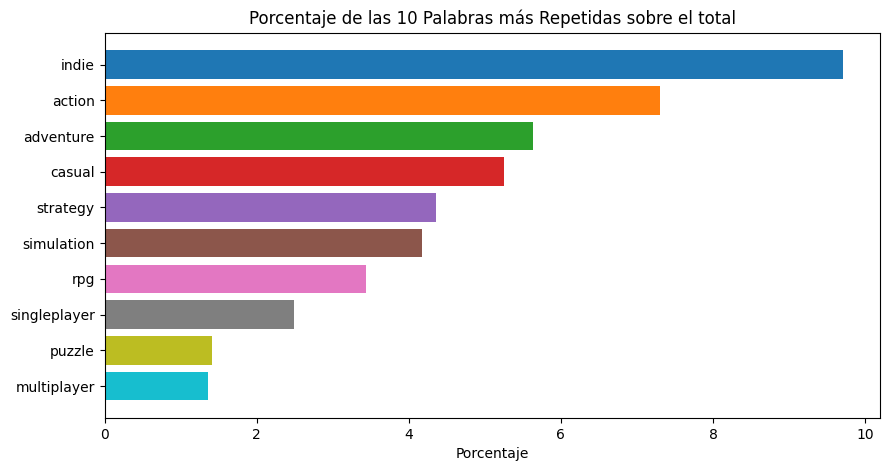

In [151]:
repres_categoricas(df_steam_games, 'tags')

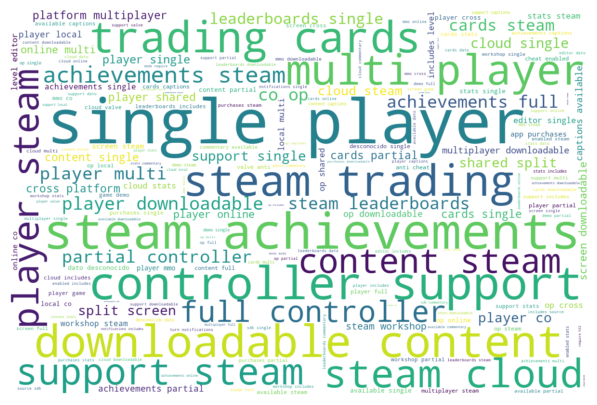

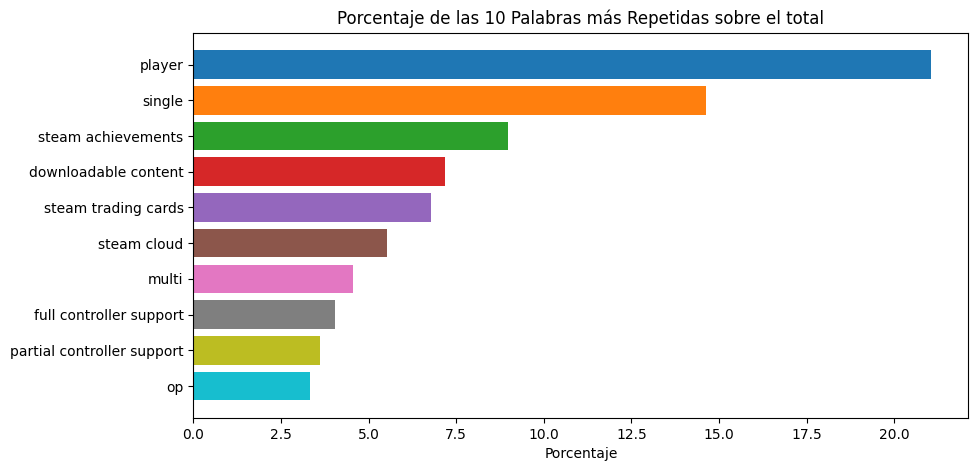

In [152]:
repres_categoricas(df_steam_games, 'specs')

c:\Users\eduen\Desktop\PI_01_STEAM\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


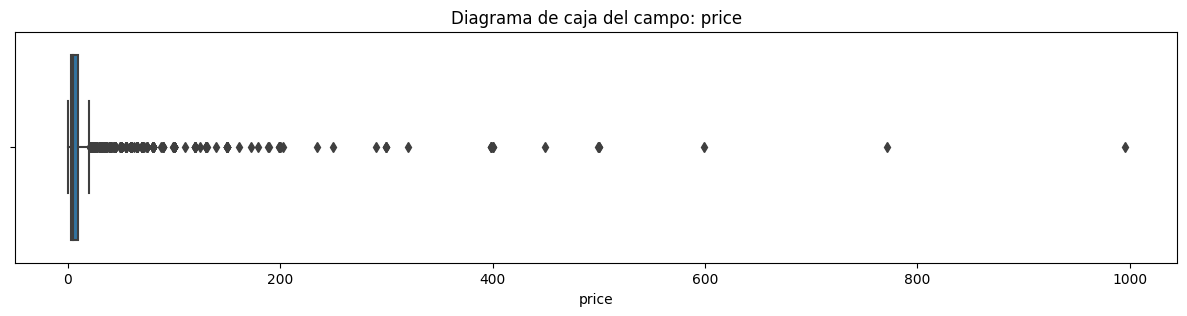

In [153]:
diagrama_caja(df_steam_games, 'price')

c:\Users\eduen\Desktop\PI_01_STEAM\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


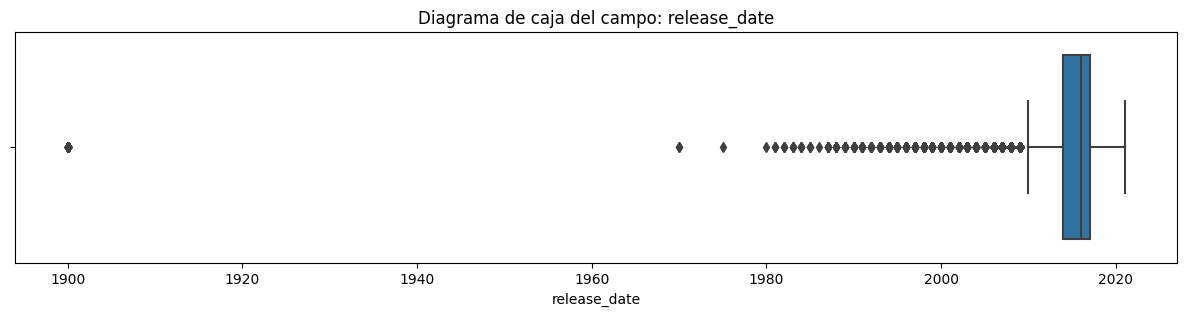

In [154]:
diagrama_caja(df_steam_games, 'release_date')

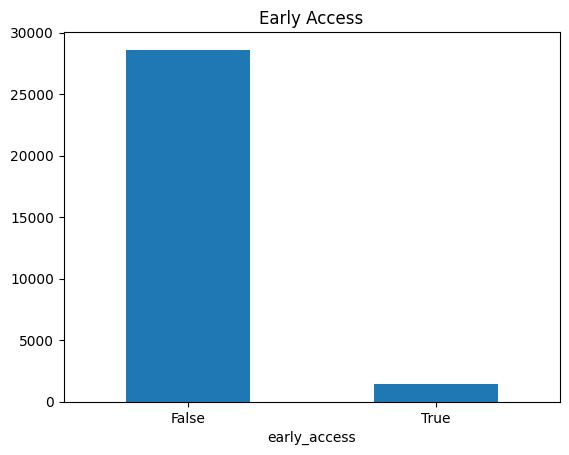

In [155]:
#Grafico de barras que arroja la frecuencia de los valores True y False del campo early_access
frecuencia = df_steam_games['early_access'].value_counts()
frecuencia.plot(kind='bar', rot=0)
plt.title('Early Access')
plt.show()

ANALISIS MULTIVARIABLE

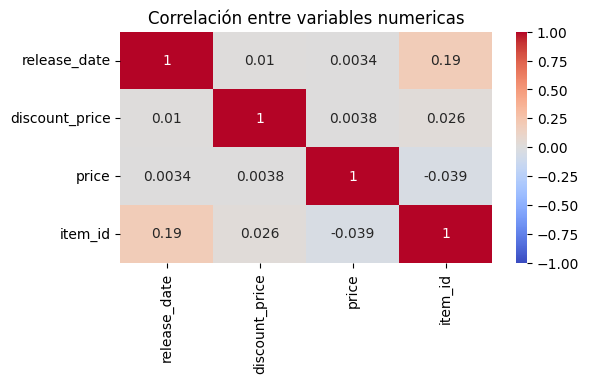

In [156]:
df = df_steam_games.select_dtypes(include=['number'])
matriz_correlacion = df.corr()
plt.figure(figsize=(6, 3))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlación entre variables numericas')
plt.show()

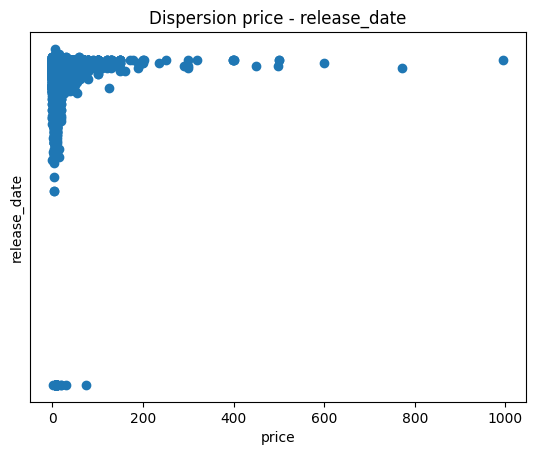

In [157]:
dispersion(df_steam_games, 'price', 'release_date')

c:\Users\eduen\Desktop\PI_01_STEAM\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\eduen\Desktop\PI_01_STEAM\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


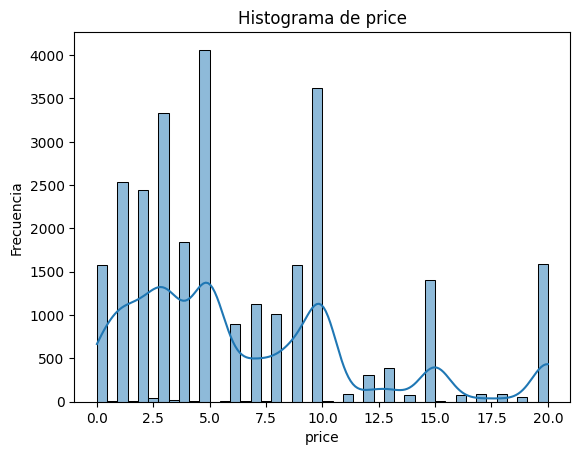

In [158]:
histograma(df_steam_games, 'price')

c:\Users\eduen\Desktop\PI_01_STEAM\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\eduen\Desktop\PI_01_STEAM\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


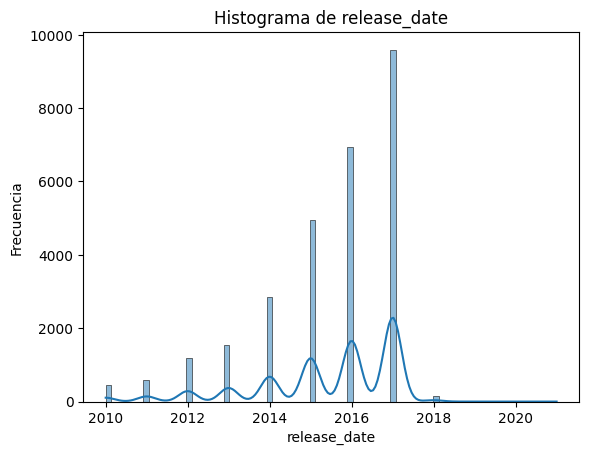

In [159]:
histograma(df_steam_games, 'release_date')

DATASET USER REVIEWS

In [114]:
user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25799 entries, 0 to 25798
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   25799 non-null  object
 1   user_url  25799 non-null  object
 2   reviews   25799 non-null  object
dtypes: object(3)
memory usage: 604.8+ KB


In [115]:
imprimir_ejemplos(user_reviews, ['reviews'])

reviews :  [{'funny': '', 'posted': 'Posted November 5, 2011.', 'last_edited': '', 'item_id': '1250', 'helpful': 'No ratings yet', 'recommend': True, 'review': 'Simple yet with great replayability. In my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth "zombie" splattering fun for the whole family. Amazed this sort of FPS is so rare.'}, {'funny': '', 'posted': 'Posted July 15, 2011.', 'last_edited': '', 'item_id': '22200', 'helpful': 'No ratings yet', 'recommend': True, 'review': "It's unique and worth a playthrough."}, {'funny': '', 'posted': 'Posted April 21, 2011.', 'last_edited': '', 'item_id': '43110', 'helpful': 'No ratings yet', 'recommend': True, 'review': 'Great atmosphere. The gunplay can be a bit chunky at times but at the end of the day this game is definitely worth it and I hope they do a sequel...so buy the game so I get a sequel!'}]


TRANSFORMACIONES
- Eliminar los campos 'funny' y 'last_edited' por no contener datos.
- Eliminar el campo 'helpful' (util) por ser irrelevante para el analisis que queremos realizar
- Transformar el campo posted a tipo de dato 'date' yyyy-mm-dd.


ETL DATASET USER_REVIEWS

C:\Users\eduen\AppData\Local\Temp\ipykernel_6476\4175722898.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_user_reviews = df_user_reviews.applymap(limpiar)
C:\Users\eduen\AppData\Local\Temp\ipykernel_6476\4175722898.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_user_reviews = df_user_reviews.applymap(str_minuscula)


,posted,item_id,recommend,review,user_id,user_url,sentiment_analysis
0,2011,1250,True,simple yet with great replayability. in my opi...,76561197970982479,http//steamcommunity.com/profiles/765611979709...,2
1,2011,22200,True,its unique and worth a playthrough.,76561197970982479,http//steamcommunity.com/profiles/765611979709...,2
2,2011,43110,True,great atmosphere. the gunplay can be a bit chu...,76561197970982479,http//steamcommunity.com/profiles/765611979709...,2
3,2014,251610,True,i know what you think when you see this title ...,js41637,http//steamcommunity.com/id/js41637,2
4,2013,227300,True,for a simple (its actually not all that simple...,js41637,http//steamcommunity.com/id/js41637,0
...,...,...,...,...,...,...,...
59300,,70,True,a must have classic from steam definitely wort...,76561198312638244,http//steamcommunity.com/profiles/765611983126...,2
59301,,362890,True,this game is a perfect remake of the original ...,76561198312638244,http//steamcommunity.com/profiles/765611983126...,2
59302,,273110,True,had so much fun plaing this and collecting res...,lydiamorley,http//steamcommunity.com/id/lydiamorley,2
59303,,730,True,d,lydiamorley,http//steamcommunity.com/id/lydiamorley,2


In [38]:
df_user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58431 entries, 0 to 59304
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   posted              58431 non-null  object
 1   item_id             58431 non-null  object
 2   recommend           58431 non-null  bool  
 3   review              58431 non-null  object
 4   user_id             58431 non-null  object
 5   user_url            58431 non-null  object
 6   sentiment_analysis  58431 non-null  int64 
dtypes: bool(1), int64(1), object(5)
memory usage: 3.2+ MB


In [168]:
df_user_reviews = pd.read_parquet('user_reviews')
df_user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58431 entries, 0 to 58430
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   posted              58431 non-null  datetime64[ns]
 1   item_id             58431 non-null  int64         
 2   recommend           58431 non-null  bool          
 3   review              58431 non-null  object        
 4   user_id             58431 non-null  object        
 5   sentiment_analysis  58431 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(2), object(2)
memory usage: 2.3+ MB


In [118]:
imprimir_ejemplos(df_user_reviews, ['posted', 'item_id', 'recommend', 'review', 'user_id'])

posted :  2011-11-05 00:00:00
item_id :  1250
recommend :  True
review :  simple yet with great replayability. in my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. alot of down to earth "zombie" splattering fun for the whole family. amazed this sort of fps is so rare.
user_id :  76561197970982479


c:\Users\eduen\Desktop\PI_01_STEAM\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\eduen\Desktop\PI_01_STEAM\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


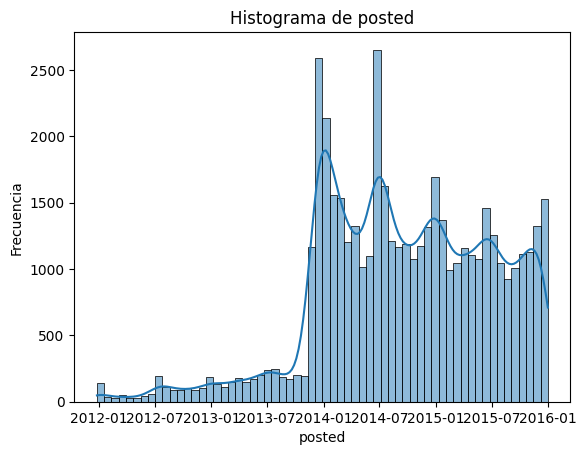

In [119]:
histograma(df_user_reviews, 'posted')

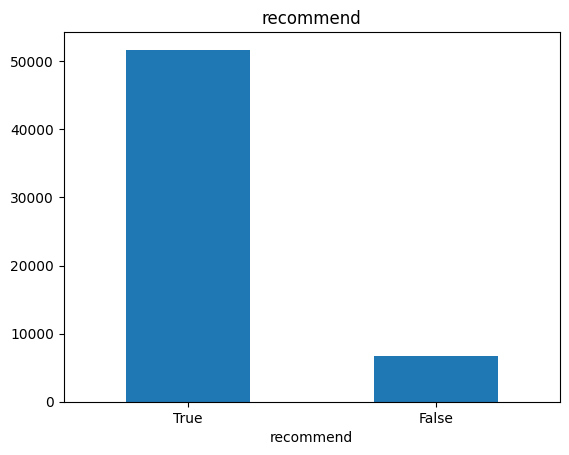

In [120]:
#Grafico de barras que arroja la frecuencia de los valores True y False del campo recommend
frecuencia = df_user_reviews['recommend'].value_counts()
frecuencia.plot(kind='bar', rot=0)
plt.title('recommend')
plt.show()

DF USERS_ITEMS

In [122]:
df_users_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88310 entries, 0 to 88309
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      88310 non-null  object
 1   items_count  88310 non-null  int64 
 2   steam_id     88310 non-null  object
 3   user_url     88310 non-null  object
 4   items        88310 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.4+ MB


In [123]:
df_users_items.head()

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."


In [124]:
imprimir_ejemplos(df_users_items, ['user_id', 'items_count', 'steam_id', 'user_url', 'items'])

user_id :  76561197970982479
items_count :  277
steam_id :  76561197970982479
user_url :  http://steamcommunity.com/profiles/76561197970982479
items :  [{'item_id': '10', 'item_name': 'Counter-Strike', 'playtime_forever': 6, 'playtime_2weeks': 0}, {'item_id': '20', 'item_name': 'Team Fortress Classic', 'playtime_forever': 0, 'playtime_2weeks': 0}, {'item_id': '30', 'item_name': 'Day of Defeat', 'playtime_forever': 7, 'playtime_2weeks': 0}, {'item_id': '40', 'item_name': 'Deathmatch Classic', 'playtime_forever': 0, 'playtime_2weeks': 0}, {'item_id': '50', 'item_name': 'Half-Life: Opposing Force', 'playtime_forever': 0, 'playtime_2weeks': 0}, {'item_id': '60', 'item_name': 'Ricochet', 'playtime_forever': 0, 'playtime_2weeks': 0}, {'item_id': '70', 'item_name': 'Half-Life', 'playtime_forever': 0, 'playtime_2weeks': 0}, {'item_id': '130', 'item_name': 'Half-Life: Blue Shift', 'playtime_forever': 0, 'playtime_2weeks': 0}, {'item_id': '300', 'item_name': 'Day of Defeat: Source', 'playtime_fo

TRANSFORMACIONES
- Eliminar el campo 'steam_id'
- Convertir 'items_count' a int.
- Desanidar el campo 'items'
- Convertir 'item_id' a int
- Convertir 'playtime_forever' a int
- Convertir 'playtime_2weeks' a int

In [125]:
contador = 0
def agregar_columnas(dato):
    global contador
    for diccionario in dato:
        diccionario['user_id'] = df_users_items.loc[contador, 'user_id']
        diccionario['items_count'] = df_users_items.loc[contador, 'items_count']
        diccionario['user_url'] = df_users_items.loc[contador, 'user_url']      
    contador += 1
    return dato
df_users_items['items'] = df_users_items['items'].apply(agregar_columnas)

df_lista = []
for i in range(len(df_users_items['items'])):
    dataframe = pd.DataFrame(df_users_items.loc[i, 'items'])
    df_lista.append(dataframe)

df_items = pd.concat(df_lista, ignore_index=True)
df_items['item_id'] = df_items['item_id'].astype(int)
df_items['items_count'] = df_items['items_count'].astype(int)
df_items['playtime_forever'] = df_items['playtime_forever'].astype(int)
df_items['playtime_2weeks'] = df_items['playtime_2weeks'].astype(int)
df_items = df_items.drop_duplicates()
df_items = df_items.applymap(str_minuscula)
df_items.to_parquet('users_items', index=False)

C:\Users\eduen\AppData\Local\Temp\ipykernel_10688\429305989.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_items = df_items.applymap(str_minuscula)


In [126]:
df_users_items = pd.read_parquet('users_items')
df_users_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5094105 entries, 0 to 5094104
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   item_id           int64 
 1   item_name         object
 2   playtime_forever  int64 
 3   playtime_2weeks   int64 
 4   user_id           object
 5   items_count       int64 
 6   user_url          object
dtypes: int64(4), object(3)
memory usage: 272.1+ MB


In [127]:
df_users_items.head()

,item_id,item_name,playtime_forever,playtime_2weeks,user_id,items_count,user_url
0,10,counter-strike,6,0,76561197970982479,277,http://steamcommunity.com/profiles/76561197970...
1,20,team fortress classic,0,0,76561197970982479,277,http://steamcommunity.com/profiles/76561197970...
2,30,day of defeat,7,0,76561197970982479,277,http://steamcommunity.com/profiles/76561197970...
3,40,deathmatch classic,0,0,76561197970982479,277,http://steamcommunity.com/profiles/76561197970...
4,50,half-life: opposing force,0,0,76561197970982479,277,http://steamcommunity.com/profiles/76561197970...


In [128]:
imprimir_ejemplos(df_users_items, ['item_id', 'item_name', 'playtime_forever', 'playtime_2weeks', 'user_id', 'items_count', 'user_url'])

item_id :  10
item_name :  counter-strike
playtime_forever :  6
playtime_2weeks :  0
user_id :  76561197970982479
items_count :  277
user_url :  http://steamcommunity.com/profiles/76561197970982479


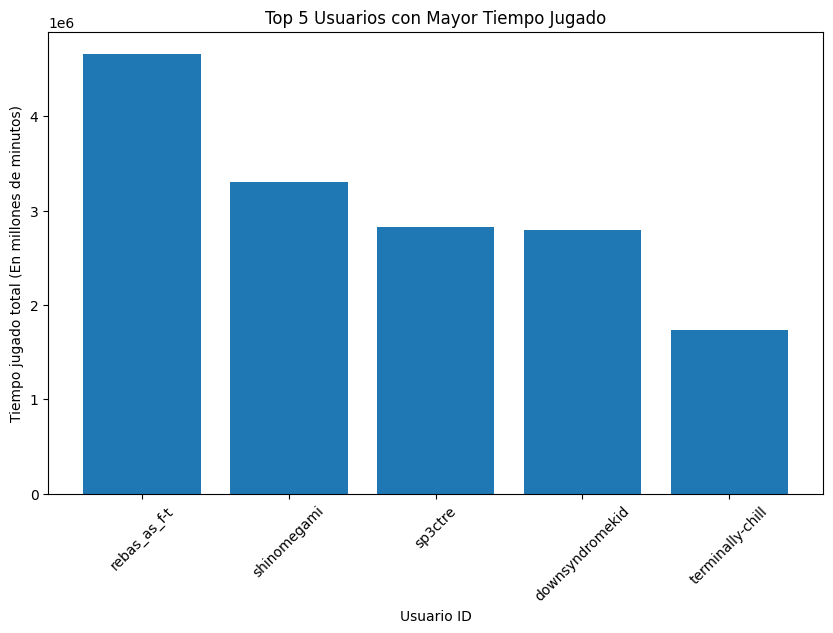

In [129]:
top_5 = df_users_items.groupby('user_id')['playtime_forever'].sum().reset_index().nlargest(5, 'playtime_forever')

plt.figure(figsize=(10, 6))
plt.bar(top_5['user_id'], top_5['playtime_forever'])
plt.xlabel('Usuario ID')
plt.ylabel('Tiempo jugado total (En millones de minutos)')
plt.title('Top 5 Usuarios con Mayor Tiempo Jugado')
plt.xticks(rotation=45)  # Rotar etiquetas del eje x
plt.show()

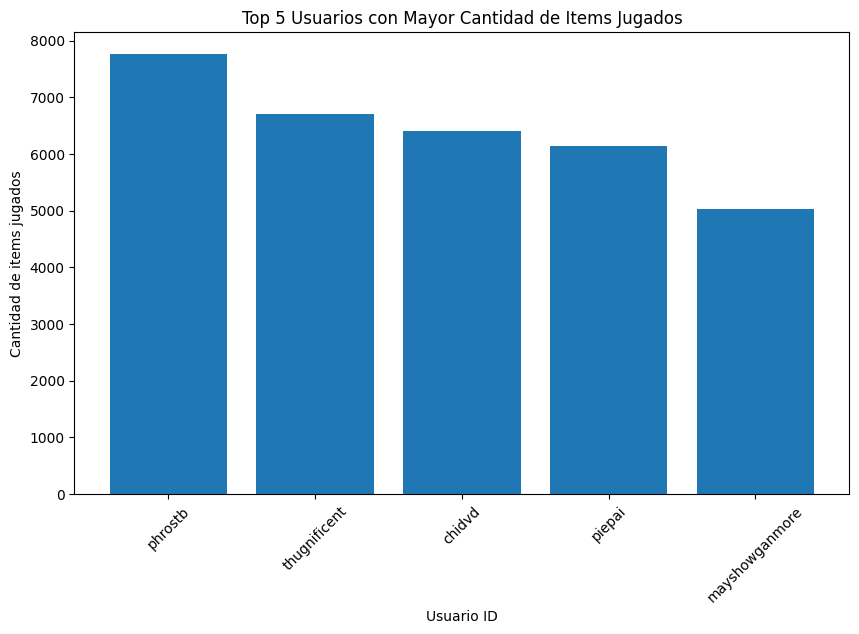

In [130]:
top_5 = df_users_items.groupby('user_id')['items_count'].max().reset_index().nlargest(5, 'items_count')

plt.figure(figsize=(10, 6))
plt.bar(top_5['user_id'], top_5['items_count'])
plt.xlabel('Usuario ID')
plt.ylabel('Cantidad de items jugados')
plt.title('Top 5 Usuarios con Mayor Cantidad de Items Jugados')
plt.xticks(rotation=45)  # Rotar etiquetas del eje x
plt.show()